In [271]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/covid19_spread'))
import pandas
import plotly.express as px
import sqlite3
from forecast_db import DB
import yaml
from datetime import timedelta
from IPython.display import SVG, display
import matplotlib.pyplot as plt
%matplotlib inline

In [272]:
conn = sqlite3.connect(':memory:')
with sqlite3.connect(DB) as conn_:
    conn_.backup(conn)

In [273]:
loc_map = {
    'new-jersey': {'loc1': 'United States', 'loc2': 'New Jersey'},
    'nystate': {'loc1': 'United States', 'loc2': 'New York'},
    'at': {'loc1': 'Austria'}
}

In [274]:
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_11_09_05/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_22_11_08/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_25_09_00/forecasts/forecast_best_rmse.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_25_08_50/forecasts/forecast_best_mae.csv'

forecast_pth = os.environ.get('FORECAST_PTH', forecast_pth)

cfg = yaml.safe_load(open(os.path.dirname(forecast_pth) + '/../cfg.yml'))
df = pandas.read_csv(forecast_pth, index_col='date', parse_dates=['date'])
var_name = f'loc{len(loc_map[cfg["region"]]) + 1}'
df = df.reset_index().melt(id_vars=['date'], value_name='counts', var_name=var_name)
for k, v in loc_map[cfg['region']].items():
    df[k] = v

df['id'] = 'this_forecast'
df['forecast_date'] = (df['date'].min() - timedelta(days=1)).date()
df.to_sql('infections', conn, if_exists='append', index=False)
basedate = (df['date'].min() - timedelta(days=1)).date()

In [275]:
cond = ' AND '.join([f"inf.{k}='{v}'" for k, v in loc_map[cfg['region']].items()])
cond += f' AND inf.loc{len(loc_map[cfg["region"]]) + 1} IS NOT NULL'

In [276]:
dates = ', '.join([f"'{d}'" for d in df['date'].dt.date.unique()])
spatial_join = ', '.join([f'loc{i}' for i in range(1, len(loc_map[cfg["region"]]) + 2)])
q = f"""
SELECT inf.loc1, inf.loc2, inf.loc3, inf.date, inf.id, inf.counts, inf.forecast_date, gt.counts AS gt
FROM infections inf
LEFT JOIN (SELECT * FROM infections WHERE forecast_date IS NULL) gt USING({spatial_join}, date)
WHERE {cond}
    AND inf.date >= '{basedate - timedelta(days=7)}'
    AND inf.forecast_date >= '{basedate - timedelta(days=7)}' 
    AND inf.forecast_date <= '{basedate}' 
"""
forecasts = pandas.read_sql(q, conn, parse_dates=['date', 'forecast_date'])
forecasts['forecast_date'] = forecasts['forecast_date'].dt.date

In [277]:
group_loc = f'loc{len(loc_map[cfg["region"]])}'
grouped = forecasts.groupby([group_loc, 'id', 'forecast_date', 'date']).sum().reset_index()
grouped['color'] = grouped['forecast_date'].apply(str) + '_' + grouped['id']

# Largest Divergence

#### A list of counties with the largest divergence from the previous forecast

In [278]:
last_date = forecasts[forecasts['id'] == f'cv_ar']['forecast_date'].max()
from datetime import date
locs = [f'loc{i}' for i in range(1, len(loc_map[cfg['region']]) + 2)]
suffixes = ('_this_forecast', f'_{last_date}')
df1 = forecasts[forecasts['id'] == 'this_forecast']
df2 = forecasts[(forecasts['id'] == 'cv_ar') & (forecasts['forecast_date'] == date(2020, 6, 24))]
x = df1.merge(df2, on=locs + ['date'], suffixes=suffixes)
x['diff'] = (x['counts_this_forecast'] - x[f'counts_{last_date}']).abs()
x['days_out'] = x['date'].dt.date - x['forecast_date_this_forecast']
cols = locs + ['date', 'days_out', 'counts_this_forecast', f'counts_{last_date}', 'diff']
x.loc[x.groupby(locs)['diff'].idxmax()].sort_values(by='diff', ascending=False)[cols].iloc[:10]

,loc1,loc2,loc3,date,days_out,counts_this_forecast,counts_2020-06-25,diff
143,United States,New York,Kings,2020-07-01,6 days,61060.838348,59702.611908,1358.226440
245,United States,New York,Queens,2020-07-01,6 days,66634.305725,65478.591011,1155.714714
311,United States,New York,Suffolk,2020-07-01,6 days,42171.481216,41366.759823,804.721394
17,United States,New York,Bronx,2020-07-01,6 days,48374.522446,47622.272011,752.250435
185,United States,New York,New York,2020-07-01,6 days,29226.012245,28549.231689,676.780556
179,United States,New York,Nassau,2020-07-01,6 days,42490.509247,41843.030682,647.478565
89,United States,New York,Erie,2020-07-01,6 days,7785.409275,7327.515791,457.893484
359,United States,New York,Westchester,2020-07-01,6 days,35180.866798,34780.449999,400.416800
167,United States,New York,Monroe,2020-07-01,6 days,3954.552284,3694.690554,259.861731
257,United States,New York,Richmond,2020-07-01,6 days,14334.155264,14078.477460,255.677804


# Forecast Trajectories

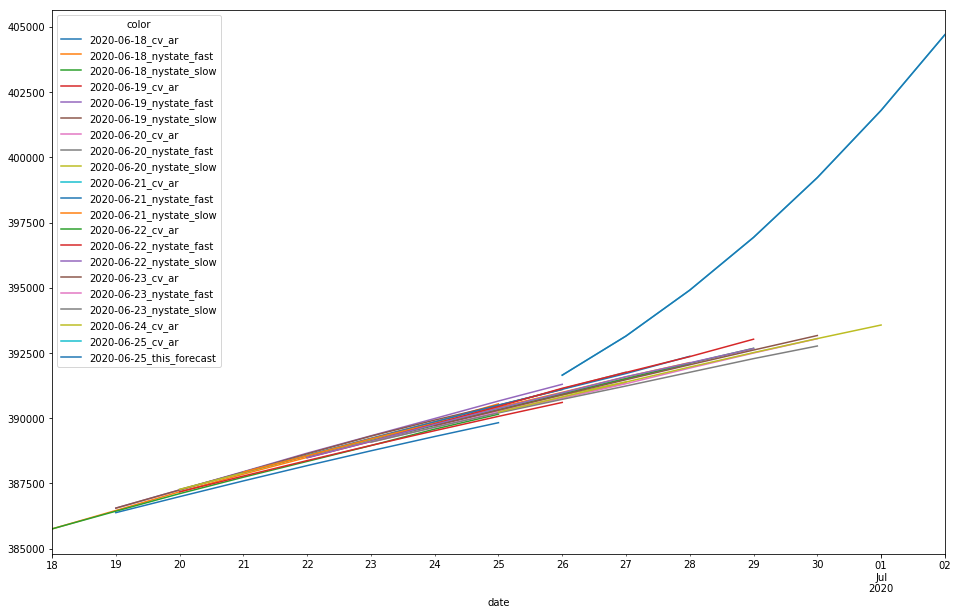

In [279]:
fig = grouped.pivot(index='date', columns='color', values='counts').plot(figsize=(16, 10))

# Mean Absolute Error

In [280]:
with_gt = forecasts[~forecasts['gt'].isnull()].copy()
with_gt['mae'] = (with_gt['gt'] - with_gt['counts']).abs()
with_gt.groupby(['forecast_date', 'id'])['mae'].mean().sort_index().to_frame()

mae
forecast_date id                    
2020-06-18    cv_ar         6.159962
              nystate_fast  5.899194
              nystate_slow  6.130376
2020-06-19    cv_ar         4.423592
              nystate_fast  4.108065
              nystate_slow  4.267742
2020-06-20    cv_ar         4.068184
              nystate_fast  3.582661
              nystate_slow  3.141129
2020-06-21    cv_ar         3.171412
              nystate_fast  2.185484
              nystate_slow  1.935484
2020-06-22    cv_ar         2.556179
              nystate_fast  1.463710
              nystate_slow  1.475806
2020-06-23    nystate_fast  0.000000
              nystate_slow  0.000000